# **INVERTED PENDULUM CONTROL USING DEEP DETERMINISTIC POLICY GRADIENT**

Importing necessary modules required for solving this problem

In [1]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

2022-07-17 21:40:10.058336: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
env = gym.make("Pendulum-v0")       # create environment

num_states = env.observation_space.shape[0]
print("Size of State Space -> {}".format(num_states))

num_actions = env.action_space.shape[0]
print("Size of Action Space -> {}".format(num_actions))

upper_bound = env.action_space.high[0]      # to scale our actions later
lower_bound = env.action_space.low[0]
print("Max Value of Action -> {}".format(upper_bound))
print("Min Value of Action -> {}".format(lower_bound))

Size of State Space -> 3
Size of Action Space -> 1
Max Value of Action -> 2.0
Min Value of Action -> -2.0


/home/arch/miniconda3/envs/python_ai/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Using noisy perturbations for better exploration by the Actor Network, like the **Ornstein-Uhlenbeck process**. This will sample noise from correlated normal distribution

In [3]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # mathematical formula for ornstein-uhlenbeck process
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) *
            np.random.normal(size=self.mean.shape)
        )
        self.x_prev = x     # store x into x_prev to make noise dependant on current one
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [4]:
# implementing Experience Replay
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        self.buffer_capacity = buffer_capacity      # maximum number of "experiences" to store
        self.batch_size = batch_size        # number of tuples to train on

        self.buffer_counter = 0     # number of times record() was called

        # different numpy arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    def record(self, obs_tuple):
        """sets index=0 if buffer_capacity exceeded, replace old records"""
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # build a static graph out of the logic and computations in our function to speed up code execution
    @tf.function        
    def update(self, state_batch, action_batch, reward_batch, next_state_batch):
        # training & updating Actor & Critic Networks
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # maximize value given by critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # compute loss & update parameters
    def learn(self):
        record_range = min(self.buffer_counter, self.buffer_capacity)       # sampling range
        batch_indices = np.random.choice(record_range, self.batch_size)     # random sample indices

        # conversion to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# update parameters slowly depending upon tau, given tau << 1 
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [5]:
def get_actor():
    # initialize weights 
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    outputs = outputs * upper_bound     # upper_bound=2.0 for pendulum
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    state_input = layers.Input(shape=(num_states))      # input State
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    action_input = layers.Input(shape=(num_actions))        # input Action
    action_out = layers.Dense(32, activation="relu")(action_input)

    # pass through separate layers before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # single value for given state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

In [6]:
# returns an action sampled from Actor network plus some noise for exploration
def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    sampled_actions = sampled_actions.numpy() + noise       # adding noise to action

    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)       # check if action within bounds

    return [np.squeeze(legal_action)]

### TRAINING HYPERPARAMETERS

In [7]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(
    1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# equal weights initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# learning rates
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 100
gamma = 0.99        # discount factor for future rewards
tau = 0.005     # update target networks

buffer = Buffer(50000, 64)

2022-07-17 21:40:12.809730: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-07-17 21:40:12.824757: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-17 21:40:12.825198: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1660 Ti with Max-Q Design computeCapability: 7.5
coreClock: 1.335GHz coreCount: 24 deviceMemorySize: 5.80GiB deviceMemoryBandwidth: 268.26GiB/s
2022-07-17 21:40:12.825230: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-07-17 21:40:12.843733: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-07-17 21:40:12.843821: I tensorflo

2022-07-17 21:40:14.004693: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-07-17 21:40:15.099391: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-07-17 21:40:15.762999: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-17 21:40:15.785631: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2601325000 Hz


Episode * 0 * Avg Reward is ==> -1456.093668843105
Episode * 1 * Avg Reward is ==> -1396.5707653006539
Episode * 2 * Avg Reward is ==> -1307.2849762693315
Episode * 3 * Avg Reward is ==> -1392.428489013574
Episode * 4 * Avg Reward is ==> -1415.1402784801671
Episode * 5 * Avg Reward is ==> -1442.2287262827297
Episode * 6 * Avg Reward is ==> -1436.8933958718158
Episode * 7 * Avg Reward is ==> -1441.4043775555695
Episode * 8 * Avg Reward is ==> -1416.6387637490452
Episode * 9 * Avg Reward is ==> -1367.154150652183
Episode * 10 * Avg Reward is ==> -1329.596883812418
Episode * 11 * Avg Reward is ==> -1294.6398739211143
Episode * 12 * Avg Reward is ==> -1256.9636579673747
Episode * 13 * Avg Reward is ==> -1223.6737423188401
Episode * 14 * Avg Reward is ==> -1189.6693980523619
Episode * 15 * Avg Reward is ==> -1148.0126354780245
Episode * 16 * Avg Reward is ==> -1111.2773969020966
Episode * 17 * Avg Reward is ==> -1078.5461143862826
Episode * 18 * Avg Reward is ==> -1048.7370742215737
Episode

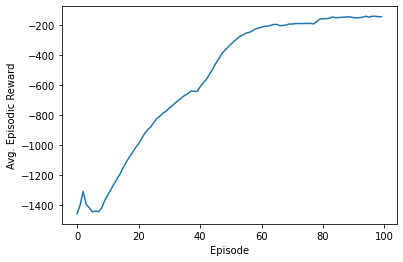

In [8]:
ep_reward_list = []     # store reward history of each episode
avg_reward_list = []        # store average reward history of last few episodes

for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0

    while True:
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)
        state, reward, done, info = env.step(action)        # receive state & reward

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        # end episode
        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    avg_reward = np.mean(ep_reward_list[-40:])      # mean of last 40 episodes
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

plt.plot(avg_reward_list)       # graph for Episodes vs Avg.rewards
plt.xlabel("Episode")
plt.ylabel("Avg. Episodic Reward")
plt.show()

In [9]:
# save weights
actor_model.save_weights("pendulum_actor.h5")
critic_model.save_weights("pendulum_critic.h5")

target_actor.save_weights("pendulum_target_actor.h5")
target_critic.save_weights("pendulum_target_critic.h5")